In [1]:
# load the necessary libraries for the project
import pandas as pd
import jieba
from collections import Counter
import string
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import spacy
import jieba.posseg as pseg
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from gensim.models import LdaMulticore, CoherenceModel
from gensim.models import TfidfModel
from gensim.matutils import sparse2full
from itertools import islice
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from transformers.pipelines import pipeline
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from umap import UMAP
from fastopic import FASTopic
import topmost
from topmost.data import RawDataset
from topmost.preprocessing import Preprocessing
# from topicgpt.TopicGPT import TopicGPT
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.graph_objs as go
import random
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import datamapplot

In [2]:
# load the csv file data
speech_df = pd.read_csv('governance_of_china_all_volumes_with_formatted_date.csv')

# sort the data by date
speech_df = speech_df.sort_values('year')

# check the first few rows of the data
speech_df.head()

title           date  \
0          就是我们的奋斗目标 * (Speech 1)  （2012年11月15日）   
38           不断推向前进 * (Speech 39)  （2012年11月16日）   
20       施行30周年大会上的讲话 (Speech 21)   （2012年12月4日）   
10  
改革开放只有进行时没有完成时 * (Speech 11)  （2012年12月31日）   
15     实实在在和没有水分的增长 * (Speech 16)  （2012年11月30日）   

                                                 text  \
0   * 这是习近平在十八届中央政治局常委同中外记者见面时讲话的主要部分。\n\n记者朋友们对十八...   
38  * 这是习近平在中央军委扩大会议上的讲话要点。\n\n军委班子和军队高级干部在领导国防和军队...   
20  同志们，朋友们：\n年12月4日，五届全国人大五次会议通过了《中华人民共和国 \n宪法》。我...   
10  * 这是习近平在主持十八届中央政治局第二次集体学习时的讲话要点。\n\n改革开放是一项长期的...   
15  * 这是习近平在中共中央召开的党外人士座谈会上的讲话要点。\n\n今年以来，面对国际经济的复...   

                                           references formatted_date  year  
0                                                 NaN     2012-11-15  2012  
38  注 释\n\n〔1〕 胡主席，即胡锦涛。\n〔2〕 毛主席，即毛泽东。\n〔3〕 邓主席，即...     2012-11-16  2012  
20  注 释\n\n〔1〕 新民主主义革命，是由无产阶级领导的、革命性质仍然是反对帝国主义反对封建...     2012-12-04  2012  
10                                                NaN     2012-12-31  2012  
15                                                NaN     2012-11-30  2012

In [28]:
# prepare the text for topic modeling
corpus = speech_df['text'] 
# remove the empty documents
corpus = [doc for doc in corpus if doc != ""]
# Remove newlines and extra whitespaces within sentences in each document
corpus = [re.sub(r'\s+', '', doc).strip() for doc in corpus]
# Remove the first sentence from each document
corpus = [re.sub(r'^[^。]*。', '', doc) for doc in corpus]
# remove the intext citations 
corpus = [re.sub(r'〔\d+〕', '', doc) for doc in corpus]

# prepare the time stamps for the data
timestamps = speech_df.year.tolist()

print(corpus[:10])
print(timestamps[:10])

['记者朋友们对十八大作了大量报道，向世界传递了许多“中国声音”。我代表大会秘书处向大家表示衷心的感谢。刚才，我们召开了中国共产党第十八届中央委员会第一次全体会议，选举产生了新一届中央领导机构，选举我为中央委员会总书记。我代表新一届中央领导机构成员感谢全党同志的信任，定当不负重托，不辱使命。全党同志的重托，全国各族人民的期望，是对我们做好工作的巨大鼓舞，也是我们肩上的重大责任。这个重大责任，就是对民族的责任。我们的民族是伟大的民族。在五千多年的文明发展历程中，中华民族为人类文明进步作出了不可磨灭的贡献。近代以后，我们的民族历经磨难，中华民族到了最危险的时候。自那时以来，为了实现中华民族伟大复兴，无数仁人志士奋起抗争，但一次又一次地失败了。中国共产党成立后，团结带领人民前仆后继、顽强奋斗，把贫穷落后的旧中国变成日益走向繁荣富强的新中国，中华民族伟大复兴展现出前所未有的光明前景。我们的责任，就是要团结带领全党全国各族人民，接过历史的接力棒，继续为实现中华民族伟大复兴而努力奋斗，使中华民族更加坚强有力地自立于世界民族之林，为人类作出新的更大的贡献。这个重大责任，就是对人民的责任。我们的人民是伟大的人民。在漫长的历史进程中，中国人民依靠自己的勤劳、勇敢、智慧，开创了各民族和睦共处的美好家园，培育了历久弥新的优秀文化。我们的人民热爱生活，期盼有更好的教育、更稳定的工作、更满意的收入、更可靠的社会保障、更高水平的医疗卫生服务、更舒适的居住条件、更优美的环境，期盼孩子们能成长得更好、工作得更好、生活得更好。人民对美好生活的向往，就是我们的奋斗目标。人世间的一切幸福都需要靠辛勤的劳动来创造。我们的责任，就是要团结带领全党全国各族人民，继续解放思想，坚持改革开放，不断解放和发展社会生产力，努力解决群众的生产生活困难，坚定不移走共同富裕的道路。这个重大责任，就是对党的责任。我们的党是全心全意为人民服务的政党。党领导人民已经取得举世瞩目的成就，我们完全有理由因此而自豪，但我们自豪而不自满，决不会躺在过去的功劳簿上。新形势下，我们党面临着许多严峻挑战，党内存在着许多亟待解决的问题。尤其是一些党员干部中发生的贪污腐败、脱离群众、形式主义、官僚主义等问题，必须下大气力解决。全党必须警醒起来。打铁还需自身硬。我们的责任，就是同全党同志一道，坚持党要管党、从严治党，切实解决自身存在的突出问题，切实

In [4]:
# load customized words for jieba
stopwords_path = "chinese_stopwords.txt"
custom_words_path = "custom_word_list.txt"

# Clear any existing dictionary settings
jieba.initialize()

# Load the custom dictionary and print confirmation
print(f"Loading custom dictionary from: {custom_words_path}")
jieba.load_userdict(custom_words_path)

# Verify if words are in the dictionary
print("Checking if '供给侧' is in dictionary:", '供给侧' in jieba.dt.FREQ)

def load_stopwords(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        stopwords = set(file.read().splitlines())
    return stopwords

stopwords = load_stopwords(stopwords_path)

def jieba_tokenizer(text):
    words = jieba.lcut(text, cut_all=False)
    filtered_tokens = []
    for word in words:
        if (word not in stopwords and 
            word.strip()): 
            filtered_tokens.append(word)
    return filtered_tokens

# Test with a specific example
test_text = "第三，必须锐意改革、大胆创新。我们面临的困难和问题，确实同国际金融危机这一外因的影响有直接关系，但内因是起决定性作用的，内因就是我们正面对着深刻的供给侧、结构性、体制性矛盾"
tokens = jieba_tokenizer(test_text)
print(tokens)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\brobo\AppData\Local\Temp\jieba.cache
Loading model cost 0.420 seconds.
Prefix dict has been built successfully.


Loading custom dictionary from: custom_word_list.txt
Checking if '供给侧' is in dictionary: True
['第三', '锐意改革', '大胆', '创新', '面临', '困难', '问题', '确实', '国际', '金融危机', '这一', '外因', '影响', '直接', '关系', '内因', '决定性', '作用', '内因', '正面', '深刻', '供给侧', '结构性', '体制性', '矛盾']


parsing texts: 100%|██████████| 337/337 [00:01<00:00, 200.24it/s]
2024-12-01 21:15:54,268 - TopMost - Real vocab size: 10000
2024-12-01 21:15:54,270 - TopMost - Real training size: 337 	 avg length: 787.172
parsing texts: 100%|██████████| 337/337 [00:01<00:00, 187.05it/s]
2024-12-01 21:17:31,020 - TopMost - Real vocab size: 10000
2024-12-01 21:17:31,022 - TopMost - Real training size: 337 	 avg length: 787.172
parsing texts: 100%|██████████| 337/337 [00:01<00:00, 187.25it/s]
2024-12-01 21:19:26,350 - TopMost - Real vocab size: 10000
2024-12-01 21:19:26,352 - TopMost - Real training size: 337 	 avg length: 787.172
parsing texts: 100%|██████████| 337/337 [00:02<00:00, 167.79it/s]
2024-12-01 21:21:19,298 - TopMost - Real vocab size: 10000
2024-12-01 21:21:19,301 - TopMost - Real training size: 337 	 avg length: 787.172
parsing texts: 100%|██████████| 337/337 [00:01<00:00, 177.29it/s]
2024-12-01 21:23:18,857 - TopMost - Real vocab size: 10000
2024-12-01 21:23:18,860 - TopMost - Real traini

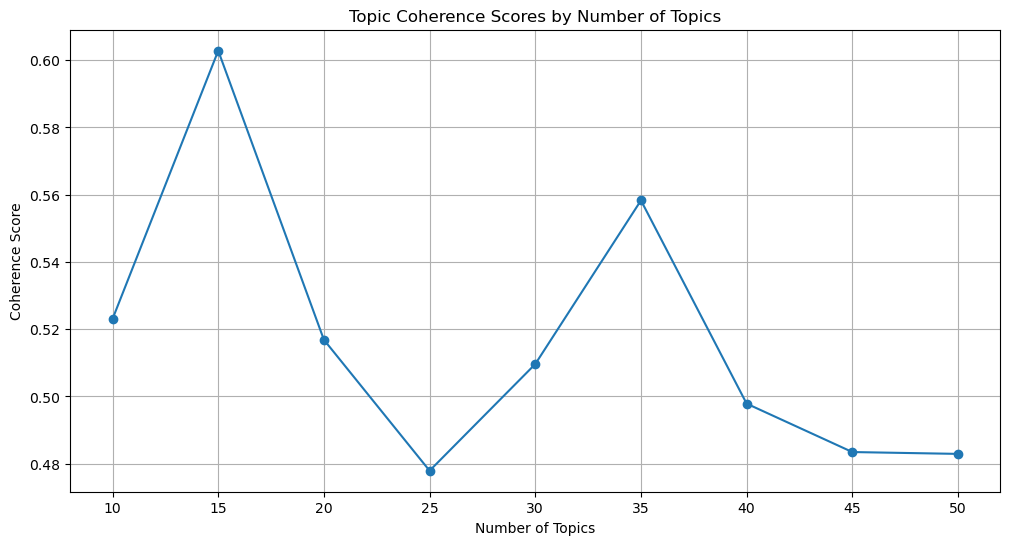


Optimal number of topics: 15
Best coherence score: 0.6028


In [5]:
def compute_coherence_values(corpus, preprocessing, doc_embed_model, topic_nums, tokenizer):
    """
    Compute coherence scores for different numbers of topics
    
    Parameters:
    ----------
    corpus : list
        List of text documents
    preprocessing : Preprocessing
        FASTopic preprocessing object
    doc_embed_model : str
        Name of the document embedding model
    topic_nums : list
        List of number of topics to try
    tokenizer : function
        Function to tokenize texts
        
    Returns:
    -------
    coherence_scores : list
        Coherence scores for each number of topics
    """
    coherence_scores = []
    
    # Prepare texts for coherence computation
    tokenized_texts = [tokenizer(text) for text in corpus]
    dictionary = Dictionary(tokenized_texts)
    
    # Create progress bar
    pbar = tqdm(topic_nums, desc="Computing coherence scores")
    
    for num_topics in pbar:
        # Train FASTopic model
        model = FASTopic(num_topics, preprocessing, doc_embed_model=doc_embed_model, verbose=False)
        top_words, train_theta = model.fit_transform(corpus)
        
        # Get topic words for coherence calculation
        topics_words = []
        for topic_idx in range(num_topics):
            # Get top 10 words for each topic
            topic_words = [word for word, _ in model.get_topic(topic_idx=topic_idx)[:10]]
            topics_words.append(topic_words)
        
        # Calculate coherence score
        coherence_model = CoherenceModel(
            topics=topics_words,
            texts=tokenized_texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        
        coherence_scores.append(coherence_model.get_coherence())
        
    return coherence_scores

def plot_coherence_scores(topic_nums, coherence_scores):
    """
    Create a scree plot of coherence scores
    """
    plt.figure(figsize=(12, 6))
    plt.plot(topic_nums, coherence_scores, marker='o')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.title('Topic Coherence Scores by Number of Topics')
    plt.grid(True)
    return plt

# Define range of topics to test
topic_nums = list(range(10, 51, 5))  # Test from 10 to 50 topics in steps of 5

preprocessing = Preprocessing(vocab_size=10000, tokenizer= jieba_tokenizer)

# Compute coherence scores
coherence_scores = compute_coherence_values(
    corpus=corpus,
    preprocessing=preprocessing,
    doc_embed_model='paraphrase-multilingual-MiniLM-L12-v2',
    topic_nums=topic_nums,
    tokenizer=jieba_tokenizer
)

# Plot results
plot = plot_coherence_scores(topic_nums, coherence_scores)
plot.show()

# Find optimal number of topics
optimal_num_topics = topic_nums[np.argmax(coherence_scores)]
print(f"\nOptimal number of topics: {optimal_num_topics}")
print(f"Best coherence score: {max(coherence_scores):.4f}")

In [ ]:
# Train final model with optimal number of topics
optimal_model = FASTopic(
    15, 
    preprocessing, 
    doc_embed_model='paraphrase-multilingual-MiniLM-L12-v2', 
    verbose=True
)
top_words, train_theta = optimal_model.fit_transform(corpus)

2024-12-01 21:47:44,744 - FASTopic - use device: cuda
parsing texts: 100%|██████████| 337/337 [00:01<00:00, 188.08it/s]
2024-12-01 21:47:50,751 - TopMost - Real vocab size: 10000
2024-12-01 21:47:50,754 - TopMost - Real training size: 337 	 avg length: 787.172
Training FASTopic: 100%|██████████| 200/200 [00:20<00:00,  9.91it/s]

Topic 0: 劳动 劳模 行不通 立足本职 模范行动 弯路 刻板 殷切期望 头破血流 粉碎 业广惟勤 思想观点 功崇惟志 坦途 广开言路
Topic 1: 救治 早 防控 卫生 生物 公共卫生 应急 外贸 融资难 安全监管 属地 废弃物 重症 多种手段 预案
Topic 2: 供给 科技 生态环境 乡村 收入 产业 高质量发展 农业 要素 共同富裕 新发展理念 需求 农村 循环 消费
Topic 3: 军民融合 网络安全 中欧 网民 网 军事战略 信息内容 上网 巴基斯坦 网上网 外交活动 精干 恐怖 物资供应 诉诸武力
Topic 4: 文艺工作者 文艺 社会科学 哲学 艺术 学科 媒体 宗教 作品 创作 家庭 传播 形象 文化自信 中华文化
Topic 5: 两岸关系 两岸 台湾 台湾同胞 青春 同胞 广大青年 少年儿童 同学 少年 两国关系 五四 中俄关系 北京大学 和平统一
Topic 6: 政法 确认 备案 干警 查找 修炼 掩饰 人民政府 查摆 军费 顽症 广大干警 谋事 执法犯法 冤假错案
Topic 7: 扶贫 贫困地区 住房 香港 脱贫攻坚 澳门 内地 脱贫 一国两制 贫困人口 帮扶 行政区 贫困 脱贫攻坚战 精准扶贫
Topic 8: 高校 群团 团组织 党校 学校 学生 学史 看齐 忘我 一颗 生死存亡 权力观 克敌制胜 知史 追求真理
Topic 9: 宪法 立法 法治 法律 司法 依法治国 依法 守法 非公有制 全面依法治国 人大 全会 社会保障 人权 机构
Topic 10: 县委书记 我军 规矩 纪律 忠诚 党章 党员 腐败 对党 批评 用人 巡视 反腐败 作风 党内
Topic 11: 核 亚洲 阿拉伯 丝绸之路 上海 一带一路 人文 友好 金砖 双方 女士们 贸易 合作 互利 进口
Topic 12: 黄河 双控 黄河流域 环保 住房问题 煤 租赁 机组 河道 资源化 左右岸 储蓄率 严重后果 消费水平 10%
Topic 13: 东盟 疫苗 多边主义 家园 气候变化 联合国 议程 发展中国家 倡议 中非 愿同 地球 东盟国家 携手 2030
Topic 14: 伟大 奋斗 马克思主义 民族 中华民族 中华民族伟大复兴 邓小平 各族人民 长征 同志 团结 时代 胜利 精神 中国共产党


In [ ]:
# display the topic diversity for the optimal model


In [23]:
optimal_model.get_topic(topic_idx=8)

(('高校', 0.0021069825),
 ('群团', 0.0018362482),
 ('团组织', 0.0018205425),
 ('党校', 0.0017377038),
 ('学校', 0.0016998488))

In [24]:
fig = optimal_model.visualize_topic(top_n=10)
fig.show()

In [25]:
optimal_model.visualize_topic_hierarchy()

In [26]:
def create_topic_visualization(model, corpus):
    """
    Create a 2D visualization of topics using UMAP reduction with accurate topic weights
    """
    # Get topic-word matrix (beta) directly using the get_beta() method
    topic_word_matrix = model.get_beta()
    num_topics = topic_word_matrix.shape[0]
    
    # Reduce dimensionality to 2D using UMAP
    umap_model = UMAP(n_components=2, random_state=42)
    topic_coords = umap_model.fit_transform(topic_word_matrix)
    
    # Get topic weights using the built-in method
    topic_weights = model.get_topic_weights()
    
    # Scale the weights to reasonable circle sizes
    # You can adjust the scaling factor (100) to make circles larger or smaller
    topic_sizes = topic_weights * 500
    
    # Get top words for each topic
    topic_words = []
    for topic_idx in range(num_topics):
        words = [word for word, _ in model.get_topic(topic_idx=topic_idx)[:5]]
        topic_words.append(' | '.join(words))
    
    # Create the scatter plot
    fig = go.Figure()
    
    # Add topics as circles
    fig.add_trace(go.Scatter(
        x=topic_coords[:, 0],
        y=topic_coords[:, 1],
        mode='markers+text',
        marker=dict(
            size=topic_sizes,  # Use the scaled weights directly
            opacity=0.7,
            color='rgba(102, 102, 255, 0.7)',
            line=dict(width=1, color='white')
        ),
        text=[f"Topic {i}<br>{words}<br>Weight: {weight:.3f}" 
              for i, (words, weight) in enumerate(zip(topic_words, topic_weights))],
        hoverinfo='text',
        textposition="top center"
    ))
    
    # Update layout with grid and axis lines
    fig.update_layout(
        title="Topic Visualization",
        xaxis=dict(
            title="UMAP Dimension 1",
            showgrid=True,
            gridwidth=1,
            gridcolor='rgba(128, 128, 128, 0.2)',
            zeroline=True,
            zerolinewidth=1,
            zerolinecolor='rgba(128, 128, 128, 0.5)',
            showline=True,
            linewidth=1,
            linecolor='rgba(128, 128, 128, 0.5)'
        ),
        yaxis=dict(
            title="UMAP Dimension 2",
            showgrid=True,
            gridwidth=1,
            gridcolor='rgba(128, 128, 128, 0.2)',
            zeroline=True,
            zerolinewidth=1,
            zerolinecolor='rgba(128, 128, 128, 0.5)',
            showline=True,
            linewidth=1,
            linecolor='rgba(128, 128, 128, 0.5)'
        ),
        showlegend=False,
        template="plotly_white",
        width=1000,
        height=800,
        plot_bgcolor='white'
    )
    
    return fig, topic_coords, topic_weights

# Create and display the visualization
topic_viz, topic_coords, topic_weights = create_topic_visualization(optimal_model, corpus)
topic_viz.show()


In [27]:
optimal_model.visualize_topic_weights(top_n=20, height=500)

In [12]:
######### BERTopic #########
# vectorize the text data using the tokenizer
jieba_vectorizer = CountVectorizer(tokenizer=jieba_tokenizer)

### KeyBERTInspired
from bertopic.representation import KeyBERTInspired
keybert_model = KeyBERTInspired()

### MMR
from bertopic.representation import MaximalMarginalRelevance
mmr_model = MaximalMarginalRelevance(diversity=0.3)

### Zero-Shot Classification
from bertopic.representation import ZeroShotClassification
candidate_topics = ['中国梦', '四个全面', '反腐倡廉', '扶贫攻坚', '一带一路', '供给侧结构性改革','共同富裕', '生态文明', '人类命运共同体']
zero_shot_model = ZeroShotClassification(candidate_topics, model = "morit/chinese_xlm_xnli")

# Create your representation model
representation_model = {
    "KeyBERT": keybert_model,
    "MMR": mmr_model,
    "Zero-Shot": zero_shot_model
}

# Create your embedding model
sentence_model = SentenceTransformer('lier007/xiaobu-embedding-v2')

hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

topic_model_jieba = BERTopic(
    embedding_model=sentence_model,
    language="multilingual",
    calculate_probabilities=True,
    verbose=True,
    vectorizer_model=jieba_vectorizer,
    representation_model=representation_model,
    hdbscan_model=hdbscan_model,
    umap_model=umap_model
    )

Testing min_cluster_sizes: 100%|██████████| 6/6 [09:18<00:00, 93.15s/it] 


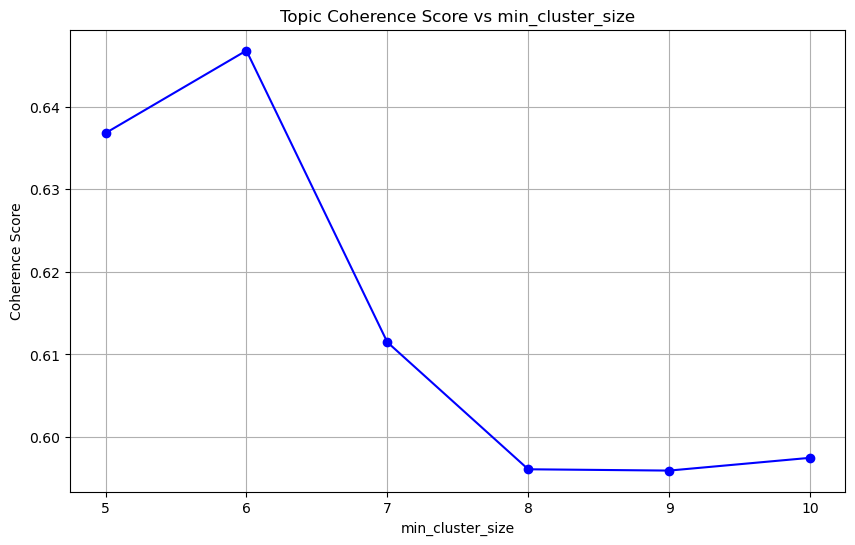

In [13]:
def optimize_min_cluster_size(texts, topic_model_base, min_size_range=range(5, 11, 1)):
    """
    Optimize min_cluster_size parameter for BERTopic using coherence scores.
    
    Parameters:
    texts: List of preprocessed documents
    topic_model_base: Base BERTopic model configuration
    min_size_range: Range of min_cluster_size values to try
    
    Returns:
    tuple: (optimal_min_size, coherence_scores, visualization)
    """
    # Tokenize all texts once
    tokenized_texts = [jieba.lcut(text) for text in texts]
    
    # Create gensim dictionary
    dictionary = Dictionary(tokenized_texts)
    
    coherence_scores = []
    
    for min_size in tqdm(min_size_range, desc="Testing min_cluster_sizes"):
        # Update HDBSCAN model with new min_cluster_size
        hdbscan_model = HDBSCAN(
            min_cluster_size=min_size,
            metric='euclidean',
            cluster_selection_method='eom',
            prediction_data=True
        )
        
        # Create new topic model with updated HDBSCAN
        topic_model = BERTopic(
            embedding_model=topic_model_base.embedding_model,
            language="multilingual",
            calculate_probabilities=True,
            verbose=False,
            vectorizer_model=topic_model_base.vectorizer_model,
            hdbscan_model=hdbscan_model,
            umap_model=topic_model_base.umap_model
        )
        
        # Fit the model
        topics, probs = topic_model.fit_transform(texts)
        
        # Get topic words for coherence calculation
        topic_words = []
        for topic in range(len(topic_model.get_topic_info())-1):  # Exclude -1 outlier topic
            words = [word for word, _ in topic_model.get_topic(topic)]
            topic_words.append(words)
        
        # Calculate coherence score
        if len(topic_words) > 0:  # Only calculate if we have topics
            coherence_model = CoherenceModel(
                topics=topic_words,
                texts=tokenized_texts,
                dictionary=dictionary,
                coherence='c_v'
            )
            coherence_score = coherence_model.get_coherence()
        else:
            coherence_score = 0
            
        coherence_scores.append(coherence_score)
        
    # Find optimal min_cluster_size
    optimal_min_size = min_size_range[np.argmax(coherence_scores)]
    
    # Create visualization
    plt.figure(figsize=(10, 6))
    plt.plot(min_size_range, coherence_scores, 'bo-')
    plt.xlabel('min_cluster_size')
    plt.ylabel('Coherence Score')
    plt.title('Topic Coherence Score vs min_cluster_size')
    plt.grid(True)
    
    return optimal_min_size, coherence_scores, plt



optimal_size, scores, plot = optimize_min_cluster_size(corpus, topic_model_jieba)

In [14]:
print(f"Optimal min_cluster_size: {optimal_size}")
plot.show()

Optimal min_cluster_size: 6


In [15]:
hdbscan_optimal = HDBSCAN(min_cluster_size=6, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
embeddings = sentence_model.encode(corpus, show_progress_bar=False)

topic_model_optimal = BERTopic(
    embedding_model=sentence_model,
    language="multilingual",
    calculate_probabilities=True,
    verbose=True,
    vectorizer_model=jieba_vectorizer,
    representation_model=representation_model,
    hdbscan_model=hdbscan_optimal,
    umap_model=umap_model
    )
topics, probs = topic_model_optimal.fit_transform(corpus)

2024-12-01 21:46:06,285 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

2024-12-01 21:46:19,299 - BERTopic - Embedding - Completed ✓
2024-12-01 21:46:19,300 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-01 21:46:20,386 - BERTopic - Dimensionality - Completed ✓
2024-12-01 21:46:20,387 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-01 21:46:20,399 - BERTopic - Cluster - Completed ✓
2024-12-01 21:46:20,401 - BERTopic - Representation - Extracting topics from clusters using representation models.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
2024-12-01 21:46:35,349 - BERTopic - Representation - Completed ✓


In [16]:
freq = topic_model_optimal.get_topic_info(); freq.head(20)

Topic  Count                  Name  \
0      -1     80        -1_发展_疫情_我国_工作   
1       0     54          0_党_政治_干部_问题   
2       1     26         1_经济_发展_合作_世界   
3       2     22         2_发展_创新_经济_科技   
4       3     22       3_合作_非洲_一带一路_中非   
5       4     21         4_两岸_人民_澳门_同胞   
6       5     18         5_制度_改革_治理_人民   
7       6     14       6_法治_法律_宪法_依法治国   
8       7     13        7_青年_青春_价值观_实现   
9       8     13       8_扶贫_脱贫攻坚_贫困_脱贫   
10      9     12         9_军队_军事_强军_国防   
11     10     10        10_文化_文艺_人民_时代   
12     11     10        11_世界_各国_合作_发展   
13     12      8        12_媒体_宣传_传播_舆论   
14     13      7  13_生态环境_生态_保护_生态文明建设   
15     14      7        14_安全_工作_风险_坚持   

                                       Representation  \
0            [发展, 疫情, 我国, 工作, 经济, 人民, 坚持, 体系, 加强, 国际]   
1       [党, 政治, 干部, 问题, 人民, 坚持, 建设, 领导, 发展, 中国特色社会主义]   
2            [经济, 发展, 合作, 世界, 各国, 亚洲, 国际, 安全, 开放, 应该]   
3             [发展, 创新, 经济, 科技, 我国, 新, 推动, 产业, 加快, 数字]   
4          [合作, 非洲, 一带一路, 中非, 共建, 发展, 东盟, 支持, 建设, 中方]   
5      [两岸, 人民, 澳门, 同胞, 两岸关系, 香港, 发展, 一国两制, 实现, 中华民族]   
6        [制度, 改革, 治理, 人民, 体系, 坚持, 发展, 社会, 全面深化改革, 方面]   
7          [法治, 法律, 宪法, 依法治国, 司法, 人民, 推进, 坚持, 立法, 人权]   
8          [青年, 青春, 价值观, 实现, 家庭, 社会, 人生, 民族, 中国梦, 时代]   
9        [扶贫, 脱贫攻坚, 贫困, 脱贫, 农村, 贫困地区, 发展, 群众, 乡村, 实现]   
10         [军队, 军事, 强军, 国防, 我军, 改革, 建设, 工作, 全军, 军民融合]   
11       [文化, 文艺, 人民, 时代, 文艺工作者, 历史, 艺术, 生活, 精神, 价值观]   
12           [世界, 各国, 合作, 发展, 人类, 共同, 经济, 文明, 应该, 全球]   
13           [媒体, 宣传, 传播, 舆论, 工作, 新闻, 思想, 文化, 网络, 信息]   
14  [生态环境, 生态, 保护, 生态文明建设, 自然, 环境保护, 发展, 生态文明, 方式,...   
15      [安全, 工作, 风险, 坚持, 维护, 重视, 总体国家安全观, 加强, 生产, 防范]   

                                              KeyBERT  \
0            [党中央, 改革, 加强, 重要, 提出, 重大, 党, 发展, 维护, 推进]   
1   [十八大, 中国特色社会主义, 党中央, 党的领导, 全党, 党和国家, 党和人民, 中国共...   
2      [尊敬, 共同发展, 维护, 十国集团, 共赢, 联合国, 中方, 应该, 各方, 全球化]   
3         [高质量发展, 发展, 创新, 加强, 重要, 推进, 增长, 要素, 体系, 动力]   
4       [共同发展, 一带一路, 共建, 中非, 中方, 共赢, 共同体, 携手, 互利, 东盟]   
5   [中华民族伟大复兴, 两岸关系, 团结, 台湾同胞, 党中央, 民族复兴, 坚决, 港澳同胞...   
6   [三中全会, 全面深化改革, 社会主义民主政治, 中国特色社会主义, 全会, 人民代表大会,...   
7   [全面依法治国, 依法治国, 中国特色社会主义, 依法, 依法行政, 宪法, 法治, 体制改...   
8   [中华民族伟大复兴, 共青团, 广大青年, 社会主义现代化, 中国特色社会主义, 中国梦, ...   
9   [脱贫攻坚战, 脱贫攻坚, 全面建成小康社会, 脱贫, 精准扶贫, 贫困县, 共同富裕, 贫...   
10  [中央军委, 军委, 国防建设, 我军, 强军, 人民军队, 战略方针, 国防, 军民融合,...   
11  [文化自信, 中国特色社会主义, 文艺工作者, 弘扬, 文艺创作, 新时代, 中华民族, 优...   
12  [人类命运共同体, 亚太经合组织, 面临, 共赢, 共建, 全球化, 多边主义, 全球治理,...   
13       [舆论导向, 加强, 重要, 党, 影响力, 团结, 意识形态, 网信, 传播, 重大]   
14  [生态文明建设, 生态文明, 绿水青山就是金山银山, 保护环境, 环境保护, 加强, 环境质...   
15  [总体国家安全观, 安全形势, 形势, 党中央, 坚决, 贯彻落实, 态势, 大局, 建立健...   

                                                  MMR  \
0              [发展, 疫情, 我国, 体系, 加强, 问题, 党, 新, 推进, 制度]   
1      [党, 干部, 问题, 中国特色社会主义, 不断, 党内, 制度, 党中央, 全党, 监督]   
2          [各国, 应该, 文明, 和平, 女士们, 共同, 核, 促进, 交流, 一带一路]   
3             [发展, 创新, 我国, 新, 战略, 问题, 优势, 提高, 重大, 构建]   
4      [一带一路, 中非, 共建, 东盟, 中方, 加强, 阿拉伯, 开展, 东盟国家, 亿美元]   
5   [两岸关系, 一国两制, 中华民族, 和平发展, 台湾同胞, 共同, 中国共产党, 中华民族...   
6   [制度, 改革, 全面深化改革, 社会主义, 中国特色社会主义, 党, 民主, 重要, 改革...   
7     [法治, 宪法, 依法治国, 全面依法治国, 依法, 社会主义, 党, 加强, 执政, 实施]   
8   [价值观, 实现, 中国梦, 广大青年, 中华民族伟大复兴, 奋斗, 新时代, 梦想, 党,...   
9   [脱贫攻坚, 脱贫, 贫困地区, 问题, 振兴, 共同富裕, 保障, 帮扶, 目标, 全面建...   
10       [强军, 我军, 全军, 党, 贯彻, 治军, 人民军队, 新时代, 中央军委, 加强]   
11  [文艺工作者, 精神, 价值观, 核心, 作品, 中华文化, 文化自信, 中华民族, 弘扬,...   
12  [发展, 共同, 文明, 应该, 金砖, 中国共产党, 发展中国家, 多边主义, 持续, 全球化]   
13             [传播, 新, 加强, 主流, 网信, 引导, 党, 领导, 融合, 群众]   
14  [保护, 生态文明建设, 环境保护, 生态文明, 制度, 节约资源, 突出, 水, 红线, 耕地]   
15      [风险, 维护, 重视, 总体国家安全观, 加强, 稳定, 重大, 体系, 挑战, 我国]   

                                            Zero-Shot  \
0   [发展, 疫情, 我国, 工作, 经济, 人民, 坚持, 体系, 加强, 国际, 建设, 社...   
1   [党, 政治, 干部, 问题, 人民, 坚持, 建设, 领导, 发展, 中国特色社会主义, ...   
2   [经济, 发展, 合作, 世界, 各国, 亚洲, 国际, 安全, 开放, 应该, 增长, 文...   
3   [发展, 创新, 经济, 科技, 我国, 新, 推动, 产业, 加快, 数字, 战略, 供给...   
4   [合作, 非洲, 一带一路, 中非, 共建, 发展, 东盟, 支持, 建设, 中方, 双方,...   
5   [两岸, 人民, 澳门, 同胞, 两岸关系, 香港, 发展, 一国

In [ ]:
# Retrieve the plotly figure from BERTopic
fig = topic_model_optimal.visualize_topics()

# Extract the topic coordinates data from the plotly figure
topic_coordinates = fig.data[0]

# Extract the coordinates and topic numbers
x_coords = topic_coordinates.x
y_coords = topic_coordinates.y
topic_numbers = topic_coordinates.customdata  # This contains the actual topic IDs as shown in the visualization

# Loop through each coordinate to add annotations
for idx in range(len(topic_numbers)):
    topic_id = topic_numbers[idx]

    # Get the coordinates for the topic's circle
    x = x_coords[idx]
    y = y_coords[idx]

    x_offset = random.uniform(-0.5, 0.5)
    y_offset = random.uniform(-0.5, 0.5)
    # Add an annotation to the figure
    fig.add_annotation(
        x=x,
        y=y,
        text=f"{topic_id}",
        showarrow=False,
        font=dict(size=10),
        opacity=0.7,
    )

# Display the modified figure
fig.show(width=1200,
    height=800)

# save the figure
fig.write_html("topic_model_optimal.html")

In [18]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model_optimal.visualize_documents(corpus, reduced_embeddings=reduced_embeddings)

In [19]:
topic_model_optimal.visualize_barchart(top_n_topics=10)


In [29]:
### dynamic topic modeling
# FASTopic
act = optimal_model.topic_activity_over_time(timestamps)
fig = optimal_model.visualize_topic_activity(top_n=10, topic_activity=act, time_slices=timestamps)
fig.show()

In [31]:
# BERTopic
# Perform dynamic topic modeling
topics_over_time = topic_model_optimal.topics_over_time(corpus, timestamps, nr_bins=11)
topic_model_optimal.visualize_topics_over_time(topics_over_time, top_n_topics=20)

11it [00:02,  5.17it/s]


In [35]:
##### topmost: TD for BERTopic and FASTopic #####
TD = topmost.evaluations.compute_topic_diversity(top_words)
print(f"TD: {TD:.5f}")

TD: 1.00000


In [47]:
from topmost.evaluations import compute_topic_diversity

def evaluate_fastopic_diversity(model, top_words, train_theta):
    """
    Evaluate topic diversity for FASTopic model using TopMost
    
    Parameters:
    -----------
    model : FASTopic model
        The fitted FASTopic model
    top_words : list
        List of space-separated strings representing top words for each topic
    train_theta : array-like
        Document-topic distribution matrix
        
    Returns:
    --------
    float
        Topic diversity score
    """
    # top_words is already in the correct format (list of space-separated strings)
    diversity_score = compute_topic_diversity(top_words)
    return diversity_score

def evaluate_bertopic_diversity(topic_model, topics, probs):
    """
    Evaluate topic diversity for BERTopic model using TopMost
    
    Parameters:
    -----------
    topic_model : BERTopic model
        The fitted BERTopic model
    topics : array-like
        Topic assignments for each document
    probs : array-like
        Topic probabilities for each document
        
    Returns:
    --------
    float
        Topic diversity score
    """
    # Get topic words from BERTopic model and convert to space-separated strings
    word_strings = []
    for topic_id, words in topic_model.get_topics().items():
        if topic_id != -1:  # Skip outlier topic
            word_string = ' '.join([word for word, _ in words])
            word_strings.append(word_string)
    
    print(word_strings)

    # Compute topic diversity
    diversity_score = compute_topic_diversity(word_strings)
    
    return word_strings, diversity_score

# Example usage with your models
# For FASTopic
fastopic_diversity = evaluate_fastopic_diversity(
    model=optimal_model,
    top_words=top_words,
    train_theta=train_theta
)

# For BERTopic
bert_top_words, bertopic_diversity = evaluate_bertopic_diversity(
    topic_model=topic_model_optimal,
    topics=topics,
    probs=probs
)

print(f"\nFASTopic Topic Diversity: {fastopic_diversity:.4f}")
print(f"BERTopic Topic Diversity: {bertopic_diversity:.4f}")

['党 政治 干部 问题 人民 坚持 建设 领导 发展 中国特色社会主义', '经济 发展 合作 世界 各国 亚洲 国际 安全 开放 应该', '发展 创新 经济 科技 我国 新 推动 产业 加快 数字', '合作 非洲 一带一路 中非 共建 发展 东盟 支持 建设 中方', '两岸 人民 澳门 同胞 两岸关系 香港 发展 一国两制 实现 中华民族', '制度 改革 治理 人民 体系 坚持 发展 社会 全面深化改革 方面', '法治 法律 宪法 依法治国 司法 人民 推进 坚持 立法 人权', '青年 青春 价值观 实现 家庭 社会 人生 民族 中国梦 时代', '扶贫 脱贫攻坚 贫困 脱贫 农村 贫困地区 发展 群众 乡村 实现', '军队 军事 强军 国防 我军 改革 建设 工作 全军 军民融合', '文化 文艺 人民 时代 文艺工作者 历史 艺术 生活 精神 价值观', '世界 各国 合作 发展 人类 共同 经济 文明 应该 全球', '媒体 宣传 传播 舆论 工作 新闻 思想 文化 网络 信息', '生态环境 生态 保护 生态文明建设 自然 环境保护 发展 生态文明 方式 环境', '安全 工作 风险 坚持 维护 重视 总体国家安全观 加强 生产 防范']

FASTopic Topic Diversity: 1.0000
BERTopic Topic Diversity: 0.6600


In [38]:
top_words

['劳动 劳模 行不通 立足本职 模范行动 弯路 刻板 殷切期望 头破血流 粉碎 业广惟勤 思想观点 功崇惟志 坦途 广开言路',
 '救治 早 防控 卫生 生物 公共卫生 应急 外贸 融资难 安全监管 属地 废弃物 重症 多种手段 预案',
 '供给 科技 生态环境 乡村 收入 产业 高质量发展 农业 要素 共同富裕 新发展理念 需求 农村 循环 消费',
 '军民融合 网络安全 中欧 网民 网 军事战略 信息内容 上网 巴基斯坦 网上网 外交活动 精干 恐怖 物资供应 诉诸武力',
 '文艺工作者 文艺 社会科学 哲学 艺术 学科 媒体 宗教 作品 创作 家庭 传播 形象 文化自信 中华文化',
 '两岸关系 两岸 台湾 台湾同胞 青春 同胞 广大青年 少年儿童 同学 少年 两国关系 五四 中俄关系 北京大学 和平统一',
 '政法 确认 备案 干警 查找 修炼 掩饰 人民政府 查摆 军费 顽症 广大干警 谋事 执法犯法 冤假错案',
 '扶贫 贫困地区 住房 香港 脱贫攻坚 澳门 内地 脱贫 一国两制 贫困人口 帮扶 行政区 贫困 脱贫攻坚战 精准扶贫',
 '高校 群团 团组织 党校 学校 学生 学史 看齐 忘我 一颗 生死存亡 权力观 克敌制胜 知史 追求真理',
 '宪法 立法 法治 法律 司法 依法治国 依法 守法 非公有制 全面依法治国 人大 全会 社会保障 人权 机构',
 '县委书记 我军 规矩 纪律 忠诚 党章 党员 腐败 对党 批评 用人 巡视 反腐败 作风 党内',
 '核 亚洲 阿拉伯 丝绸之路 上海 一带一路 人文 友好 金砖 双方 女士们 贸易 合作 互利 进口',
 '黄河 双控 黄河流域 环保 住房问题 煤 租赁 机组 河道 资源化 左右岸 储蓄率 严重后果 消费水平 10%',
 '东盟 疫苗 多边主义 家园 气候变化 联合国 议程 发展中国家 倡议 中非 愿同 地球 东盟国家 携手 2030',
 '伟大 奋斗 马克思主义 民族 中华民族 中华民族伟大复兴 邓小平 各族人民 长征 同志 团结 时代 胜利 精神 中国共产党']

In [48]:
bert_top_words

['党 政治 干部 问题 人民 坚持 建设 领导 发展 中国特色社会主义',
 '经济 发展 合作 世界 各国 亚洲 国际 安全 开放 应该',
 '发展 创新 经济 科技 我国 新 推动 产业 加快 数字',
 '合作 非洲 一带一路 中非 共建 发展 东盟 支持 建设 中方',
 '两岸 人民 澳门 同胞 两岸关系 香港 发展 一国两制 实现 中华民族',
 '制度 改革 治理 人民 体系 坚持 发展 社会 全面深化改革 方面',
 '法治 法律 宪法 依法治国 司法 人民 推进 坚持 立法 人权',
 '青年 青春 价值观 实现 家庭 社会 人生 民族 中国梦 时代',
 '扶贫 脱贫攻坚 贫困 脱贫 农村 贫困地区 发展 群众 乡村 实现',
 '军队 军事 强军 国防 我军 改革 建设 工作 全军 军民融合',
 '文化 文艺 人民 时代 文艺工作者 历史 艺术 生活 精神 价值观',
 '世界 各国 合作 发展 人类 共同 经济 文明 应该 全球',
 '媒体 宣传 传播 舆论 工作 新闻 思想 文化 网络 信息',
 '生态环境 生态 保护 生态文明建设 自然 环境保护 发展 生态文明 方式 环境',
 '安全 工作 风险 坚持 维护 重视 总体国家安全观 加强 生产 防范']

In [49]:
compute_topic_diversity(top_words)

1.0

In [50]:
compute_topic_diversity(bert_top_words)

0.66